In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

# Montar Google Drive
drive.mount('/gdrive')

# Leer el conjunto de datos
ruta = '/gdrive/MyDrive/data-10.csv'
df = pd.read_csv(ruta)
df

Mounted at /gdrive


,Date,Value,Anomaly,Monthly Mean
0,199001,4.87,-0.17,5.04
1,199002,3.04,-0.05,3.09
2,199003,3.97,-0.11,4.08
3,199004,7.00,0.05,6.95
4,199005,9.72,-0.57,10.29
...,...,...,...,...
401,202306,11.02,-2.44,13.46
402,202307,13.49,-2.58,16.07
403,202308,15.50,-2.34,17.84
404,202309,16.80,-1.81,18.61


In [ ]:
df ['Date'] .dtype

dtype('int64')

In [ ]:
df['datetime']=pd.to_datetime(
    df['Date'],
    format='%Y%m'
)
# Establece la nueva columna como índice
df = df.set_index('datetime')
# Ordena el conjunto de datos en orden ascendente
df.sort_index(inplace=True)
df = df.drop(columns=['Date'])
df

,Value,Anomaly,Monthly Mean
datetime,,,
1990-01-01,4.87,-0.17,5.04
1990-02-01,3.04,-0.05,3.09
1990-03-01,3.97,-0.11,4.08
1990-04-01,7.00,0.05,6.95
1990-05-01,9.72,-0.57,10.29
...,...,...,...
2023-06-01,11.02,-2.44,13.46
2023-07-01,13.49,-2.58,16.07
2023-08-01,15.50,-2.34,17.84


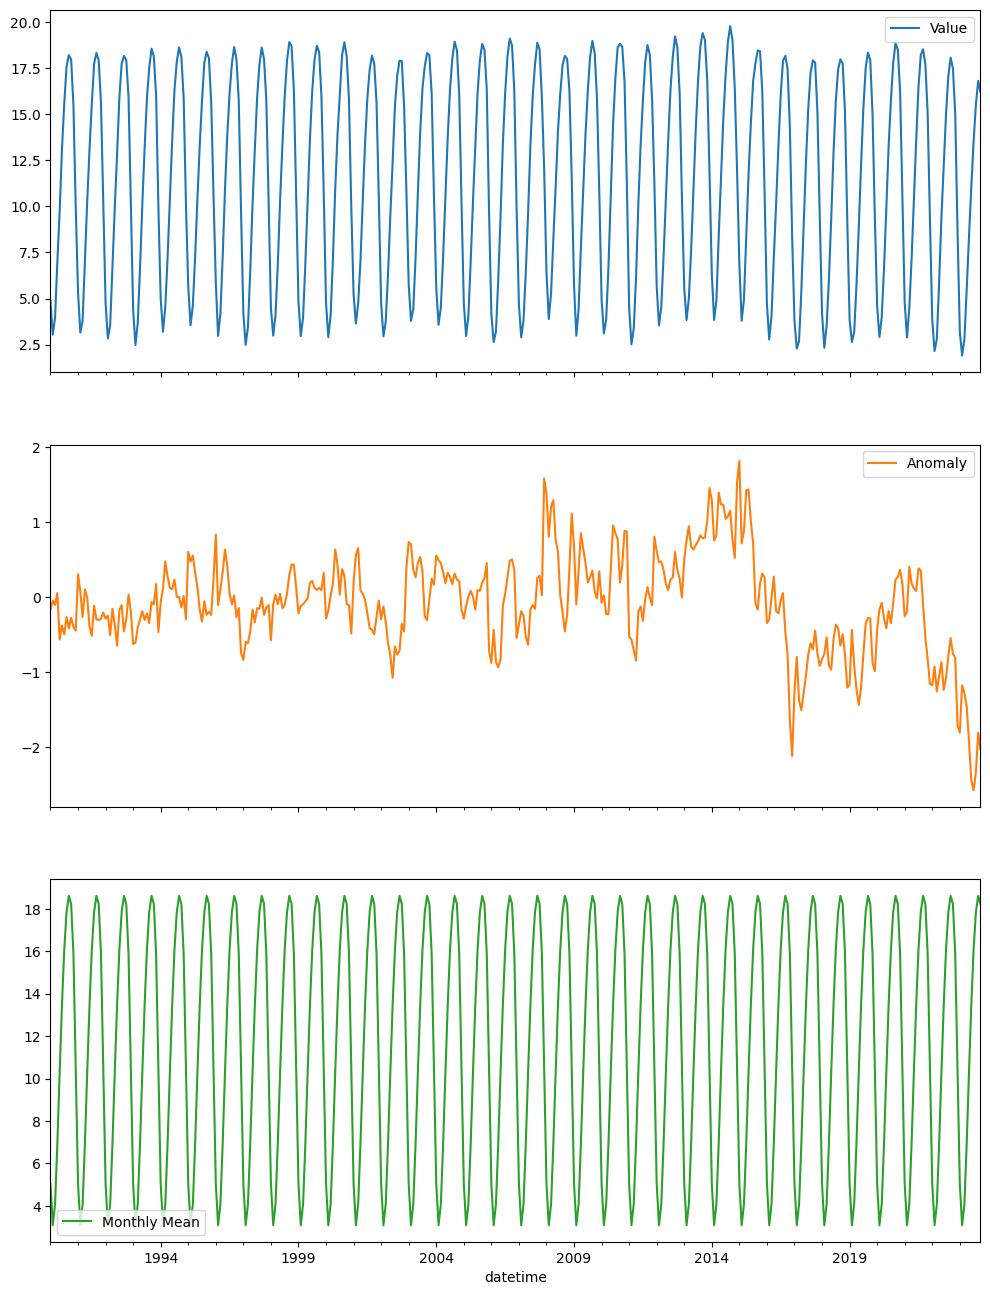

In [ ]:
#dibujamos nuestras variables
cols = df.columns
N = df.shape[0]
plots = df[cols][0:N]
plots.index = df.index[0:N]
__ = plots.plot(subplots=True, figsize=(12, 16))

In [ ]:
#verificar si hay datos faltantes
print ('Cantidad de NaNs ')
for column in df:
    nans = df[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs 
	Columna Value: 0
	Columna Anomaly: 0
	Columna Monthly Mean: 0


In [ ]:
# Assuming 'df' is the DataFrame you want to save
df.to_csv(ruta + 'prepocesados.csv')

In [ ]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df['Monthly Mean'])

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (324,)
Tamaño set de validación: (40,)
Tamaño set de prueba: (42,)


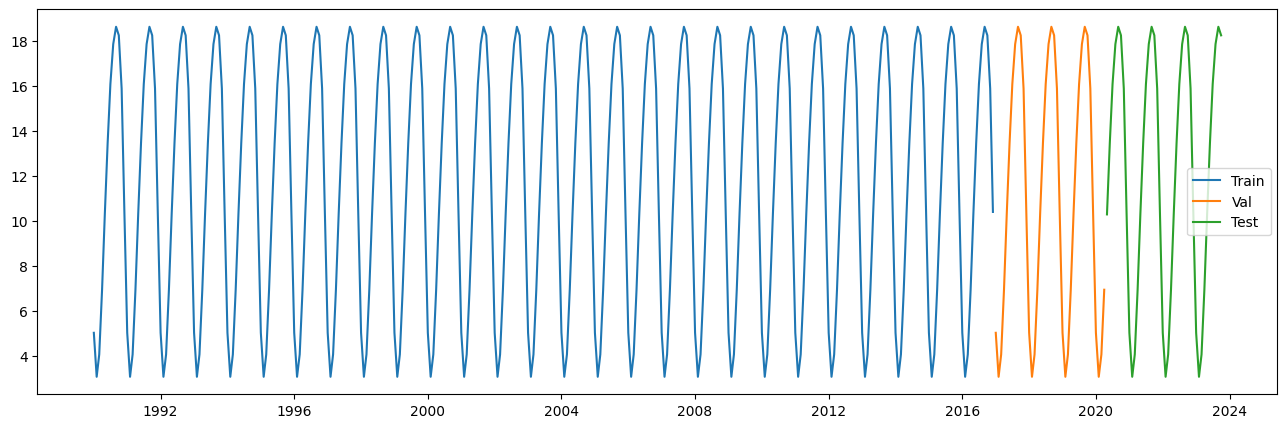

In [ ]:
# Dibujemos los subsets
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr, label='Train')
ax.plot(vl, label='Val')
ax.plot(ts, label='Test')
plt.legend();

In [ ]:
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [ ]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 12   # Registros de 12 meses consecutivos a la entrada
OUTPUT_LENGTH = 1    # El modelo va a predecir 1 mes a futuro


x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (311, 12, 1), y_tr: (311, 1, 1)
Set de validación - x_vl: (27, 12, 1), y_vl: (27, 1, 1)
Set de prueba - x_ts: (29, 12, 1), y_ts: (29, 1, 1)


In [ ]:
import numpy as np

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

In [ ]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar
data_s, scaler = escalar_dataset(data_in)

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificación
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')


Min x_tr/x_vl/x_ts sin escalamiento: 3.09/3.09/3.09
Min x_tr/x_vl/x_ts con escalamiento: -0.9999999999999999/-0.9999999999999999/-0.9999999999999999

Min y_tr/y_vl/y_ts sin escalamiento: 3.09/3.09/3.09
Min y_tr/y_vl/y_ts con escalamiento: -0.9999999999999999/-0.9999999999999999/-0.9999999999999999

Max x_tr/x_vl/x_ts sin escalamiento: 18.61/18.61/18.61
Max x_tr/x_vl/x_ts con escalamiento: 1.0000000000000004/1.0000000000000004/1.0000000000000004

Max y_tr/y_vl/y_ts sin escalamiento: 18.61/18.61/18.61
Max y_tr/y_vl/y_ts con escalamiento: 1.0000000000000004/1.0000000000000004/1.0000000000000004


In [ ]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 30  # Tamaño del estado oculto (h) y de la celdad de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 6 (medias mensuales) x 1 (feature)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de los km
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 100 # Hiperparámetro
BATCH_SIZE = 16 # para multistep # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 2s - 109ms/step - loss: 0.7125 - val_loss: 0.7420
Epoch 2/100
20/20 - 0s - 8ms/step - loss: 0.7079 - val_loss: 0.7377
Epoch 3/100
20/20 - 0s - 15ms/step - loss: 0.7038 - val_loss: 0.7336
Epoch 4/100
20/20 - 0s - 16ms/step - loss: 0.6997 - val_loss: 0.7294
Epoch 5/100
20/20 - 0s - 9ms/step - loss: 0.6957 - val_loss: 0.7252
Epoch 6/100
20/20 - 0s - 9ms/step - loss: 0.6916 - val_loss: 0.7211
Epoch 7/100
20/20 - 0s - 10ms/step - loss: 0.6876 - val_loss: 0.7169
Epoch 8/100
20/20 - 0s - 14ms/step - loss: 0.6835 - val_loss: 0.7127
Epoch 9/100
20/20 - 0s - 8ms/step - loss: 0.6794 - val_loss: 0.7085
Epoch 10/100
20/20 - 0s - 8ms/step - loss: 0.6754 - val_loss: 0.7043
Epoch 11/100
20/20 - 0s - 7ms/step - loss: 0.6713 - val_loss: 0.7000
Epoch 12/100
20/20 - 0s - 8ms/step - loss: 0.6671 - val_loss: 0.6957
Epoch 13/100
20/20 - 0s - 15ms/step - loss: 0.6630 - val_loss: 0.6914
Epoch 14/100
20/20 - 0s - 15ms/step - loss: 0.6588 - val_loss: 0.6871
Epoch 15/100
20/20 - 0s - 7ms/step - loss: 0.65

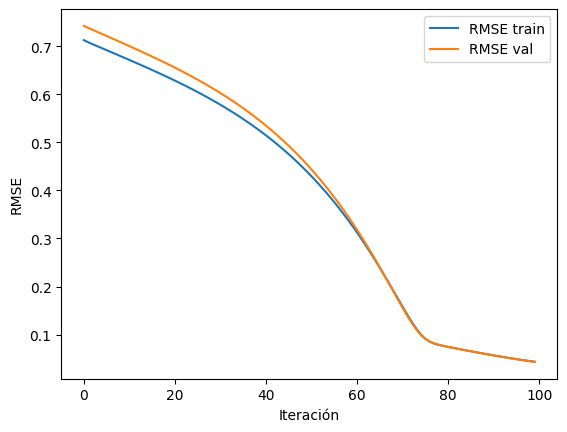

In [ ]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

In [ ]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.044
  RMSE val:	 0.043
  RMSE test:	 0.042


In [ ]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()


In [ ]:
# Llama a la función predecir con los argumentos apropiados para obtener las predicciones
y_pred = predecir(x_ts_s, modelo, scaler) # Asumiendo que quieres predecir en el conjunto de prueba

In [ ]:
 y_ts_pred = predecir(x_ts_s, modelo, scaler)


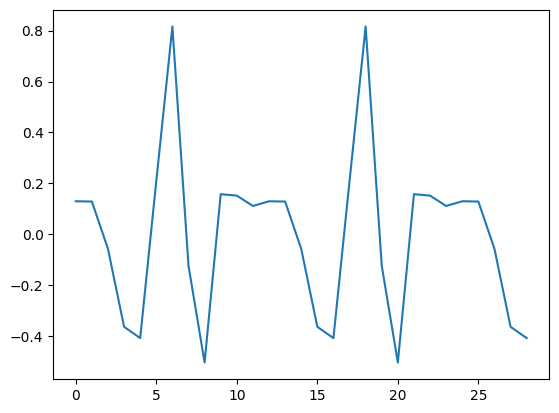

In [ ]:
  N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

In [ ]:
print(y_ts_pred)


[10.160095  13.3312235 16.127005  18.203175  19.01762   18.021006
 15.053632  10.523511   5.5433083  2.9323347  3.9278796  6.838635
 10.160095  13.3312235 16.127005  18.203175  19.01762   18.021006
 15.053632  10.523511   5.5433083  2.9323347  3.9278796  6.838635
 10.160095  13.3312235 16.127005  18.203175  19.017618 ]


In [ ]:
print(y_ts.flatten())

[10.29 13.46 16.07 17.84 18.61 18.23 15.87 10.4   5.04  3.09  4.08  6.95
 10.29 13.46 16.07 17.84 18.61 18.23 15.87 10.4   5.04  3.09  4.08  6.95
 10.29 13.46 16.07 17.84 18.61]


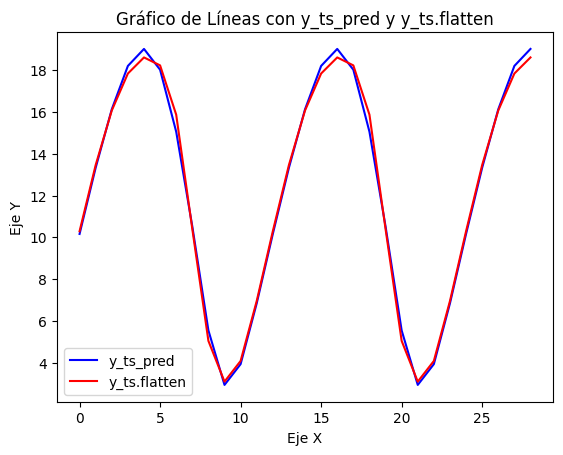

In [ ]:
import matplotlib.pyplot as plt

# Supongamos que y_ts_pred y y_ts.flatten son tus datos

# Graficar cada variable con un color distinto
plt.plot(y_ts_pred, color='blue', label='y_ts_pred')   # Línea en azul
plt.plot(y_ts.flatten(), color='red', label='y_ts.flatten')  # Línea en rojo

# Añadir etiquetas y título
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Gráfico de Líneas con y_ts_pred y y_ts.flatten')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
def predecir_multiples_pasos(modelo, scaler, datos_iniciales, n_pasos):
    """
    This function performs multiple-step time series forecasting.

    Args:
        modelo: The trained time series model.
        scaler: The scaler used for data preprocessing.
        datos_iniciales: The initial data point for prediction.
        n_pasos: The number of time steps to predict.

    Returns:
        A list of predictions for the next n_pasos time steps.
    """
    predicciones = []
    datos_actuales = datos_iniciales.copy()  # Start with initial data

    for _ in range(n_pasos):
        # Make a prediction for the next time step
        dato_escalado = scaler.transform(datos_actuales.reshape(-1, 1))
        prediccion_escalada = modelo.predict(dato_escalado)
        prediccion = scaler.inverse_transform(prediccion_escalada)

        # Add the prediction to the list
        predicciones.append(prediccion[0, 0])

        # Update the current data for the next prediction
        datos_actuales = np.append(datos_actuales[1:], prediccion)

    # Print predictions
    for i, prediccion in enumerate(predicciones):
        print(f"Predicción mes {i+1}: {prediccion:.2f}")

    return predicciones